In [13]:
import torch
import torch.nn.functional as F
from torch.utils.data import random_split, TensorDataset


from captum.attr import IntegratedGradients, NoiseTunnel, GradientShap, Occlusion, visualization as viz

import numpy as np
import matplotlib.pyplot as plt

from CustomCNN import CustomCNN

In [14]:
# Default device plus free memory
torch.cuda.empty_cache()
#device = "cpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
# Instantiate the model
chanels = 32
kernel_size = 3
model = CustomCNN(chanels, kernel_size)

# Load the weights
model.load_state_dict(torch.load("./Models/custom_cnn_custom_dataset.pth"))
model.eval()  # Set the model to evaluation mode

CustomCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4)

In [16]:
data_easy = torch.load('./data/CustomDataset/easier.pth')
data_harder = torch.load('./data/CustomDataset/harder.pth')
data_vary_disk = torch.load('./data/CustomDataset/vary_disk.pth')

images = torch.cat((data_easy['images'],
                    data_harder['images'],
                    data_vary_disk['images']))

images = images.float()
labels = torch.cat((data_easy['labels'],
                    data_harder['labels'],
                    data_vary_disk['labels']))

In [17]:
# Create dataset
dataset = TensorDataset(images.unsqueeze(1), labels)  # Add channel dimension

# Split dataset: 80% for training and 20% for validation/testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [18]:
# Pick two images for each digit
selected_images = {i: [] for i in range(2)}
selected_labels = {i: [] for i in range(2)}

for image, label in test_dataset:
    if len(selected_images[label.item()]) < 10:
        selected_images[label.item()].append(image)
        selected_labels[label.item()].append(label)

    # Break if we have collected 2 images for each digit
    if all(len(images) == 10 for images in selected_images.values()):
        break

# Verification
for label, images in selected_images.items():
    print(f"For class {label}, selected {len(images)} images.")

For class 0, selected 10 images.
For class 1, selected 10 images.


In [19]:
# To store results for all images
results = []

# Iterate over labels and their corresponding images
for label, images in selected_images.items():
    for idx, image in enumerate(images):
        # Add batch dimension and run the model
        with torch.no_grad():
            image = image.unsqueeze(0)  # Add batch dimension
            output = model(image)
            predicted_label = torch.argmax(output).item()
            probabilities = F.softmax(output, dim=1)  # Apply softmax to get the probabilities
            prediction_score = probabilities[0][predicted_label].item()  # Confidence score for the predicted label
        
        # Store the results
        result = {
            "True Label": label,
            "Predicted Label": predicted_label,
            "Confidence Score": prediction_score,
            "Probability Distribution": probabilities[0].tolist()
        }
        results.append(result)

# Displaying the results
for res in results:
    print(f"True Label: {res['True Label']}")
    print(f"Predicted Label: {res['Predicted Label']}")
    print(f"Confidence Score for the Predicted Label: {res['Confidence Score']:.4f}")
    print(f"Probability Distribution over Classes: {res['Probability Distribution']}")
    print("="*50)

True Label: 0
Predicted Label: 0
Confidence Score for the Predicted Label: 1.0000
Probability Distribution over Classes: [0.9999513626098633, 4.8651167162461206e-05]
True Label: 0
Predicted Label: 0
Confidence Score for the Predicted Label: 0.9999
Probability Distribution over Classes: [0.9998596906661987, 0.0001403173228027299]
True Label: 0
Predicted Label: 0
Confidence Score for the Predicted Label: 0.9998
Probability Distribution over Classes: [0.9998435974121094, 0.00015638071636203676]
True Label: 0
Predicted Label: 0
Confidence Score for the Predicted Label: 0.9999
Probability Distribution over Classes: [0.9998575448989868, 0.0001424730144208297]
True Label: 0
Predicted Label: 0
Confidence Score for the Predicted Label: 0.9999
Probability Distribution over Classes: [0.9999343156814575, 6.565137300640345e-05]
True Label: 0
Predicted Label: 0
Confidence Score for the Predicted Label: 1.0000
Probability Distribution over Classes: [0.9999889135360718, 1.1071996596001554e-05]
True La

In [20]:
integrated_gradients = IntegratedGradients(model)

# Store the attributions for each image
attributions_list = []

# Iterate over images and results
for (label, images), res in zip(selected_images.items(), results):
    for idx, image in enumerate(images):
        predicted_label = res["Predicted Label"]  # Retrieve the predicted label from results
        transformed_img = image.unsqueeze(0)  # Add batch dimension and send to device

        # Compute the attributions using Integrated Gradients
        attributions_ig = integrated_gradients.attribute(transformed_img, target=predicted_label, n_steps=20)
        attributions_list.append(attributions_ig)

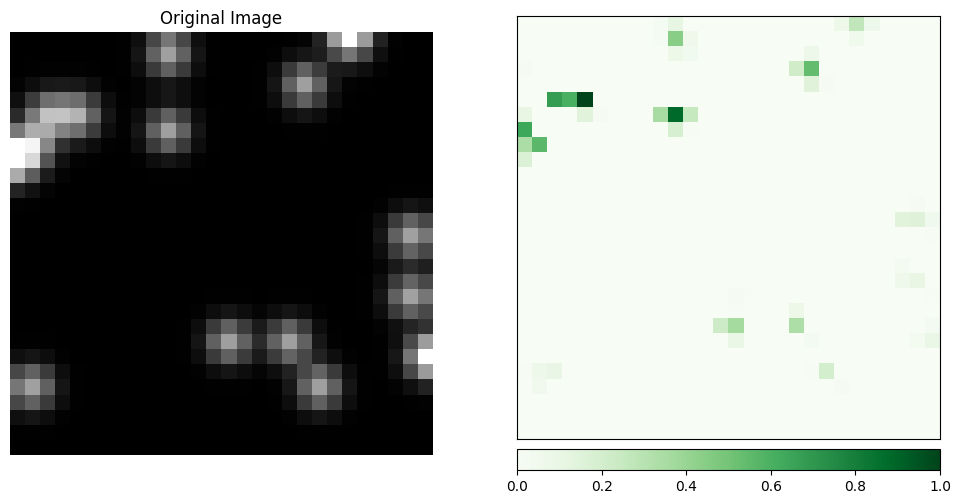

<Figure size 640x480 with 0 Axes>

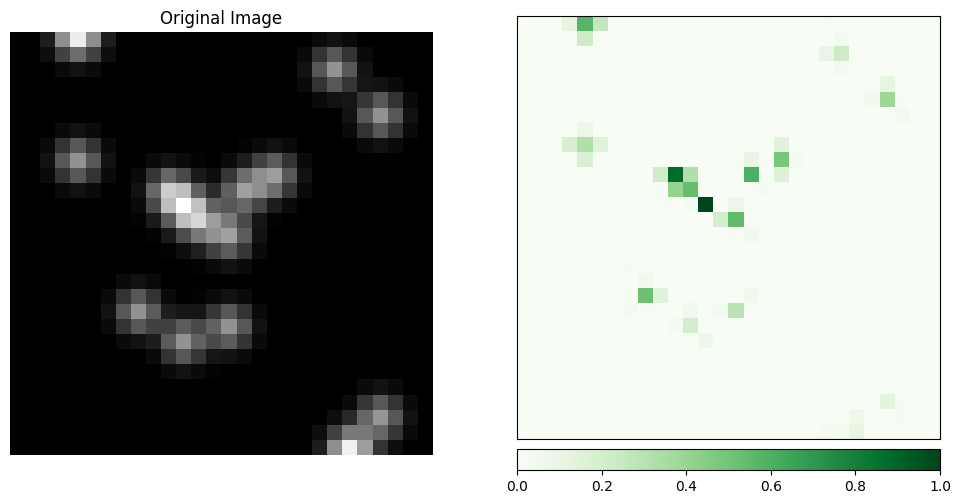

<Figure size 640x480 with 0 Axes>

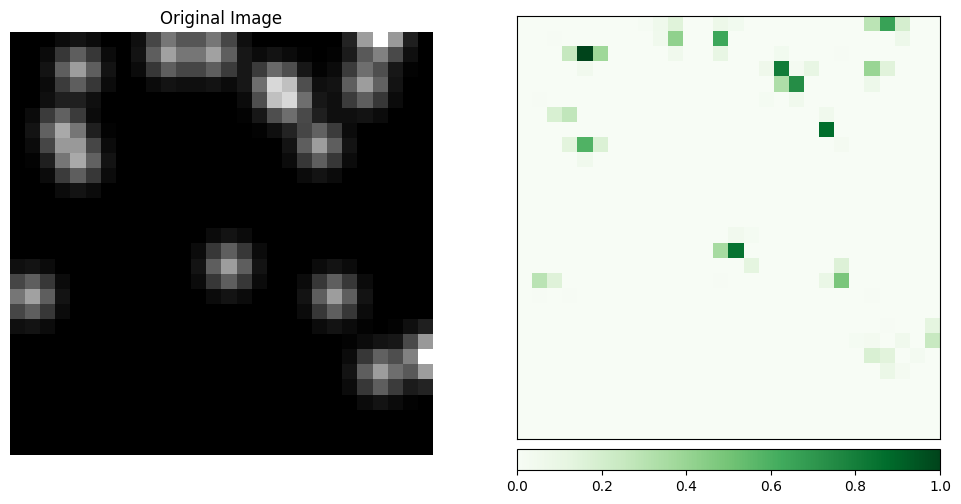

<Figure size 640x480 with 0 Axes>

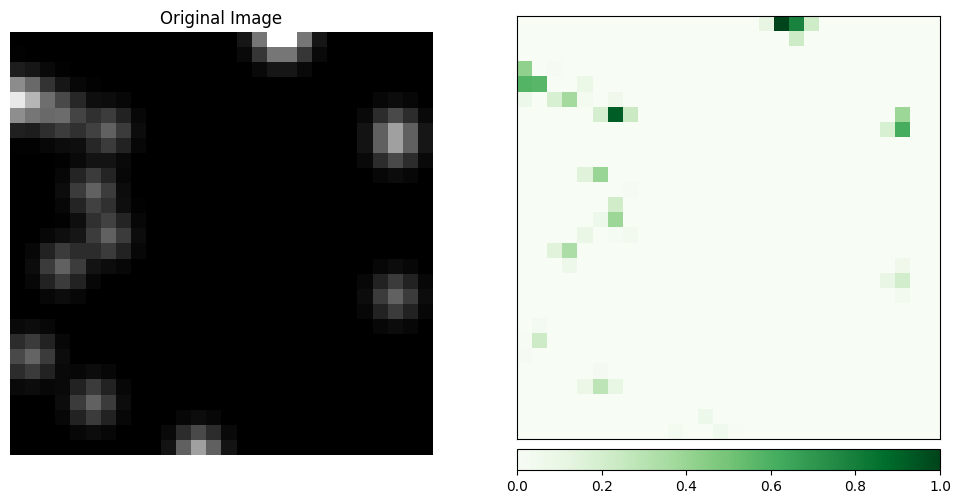

<Figure size 640x480 with 0 Axes>

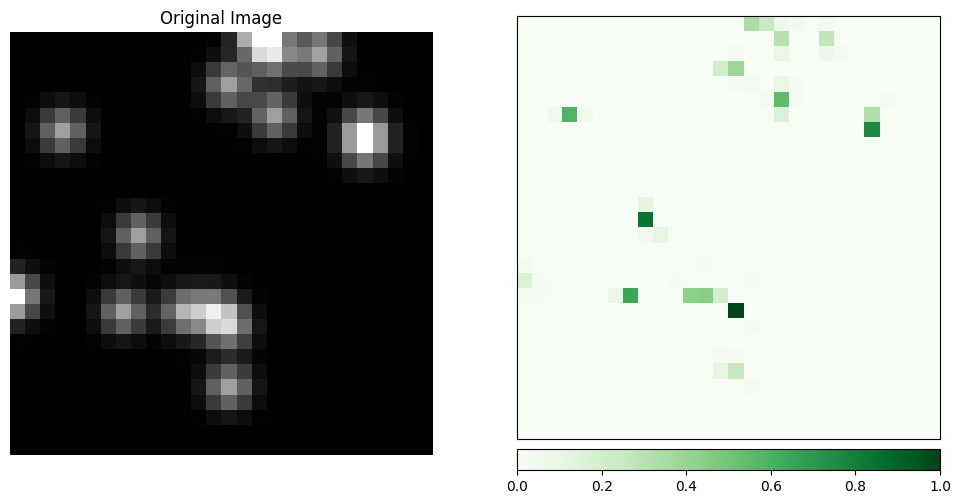

<Figure size 640x480 with 0 Axes>

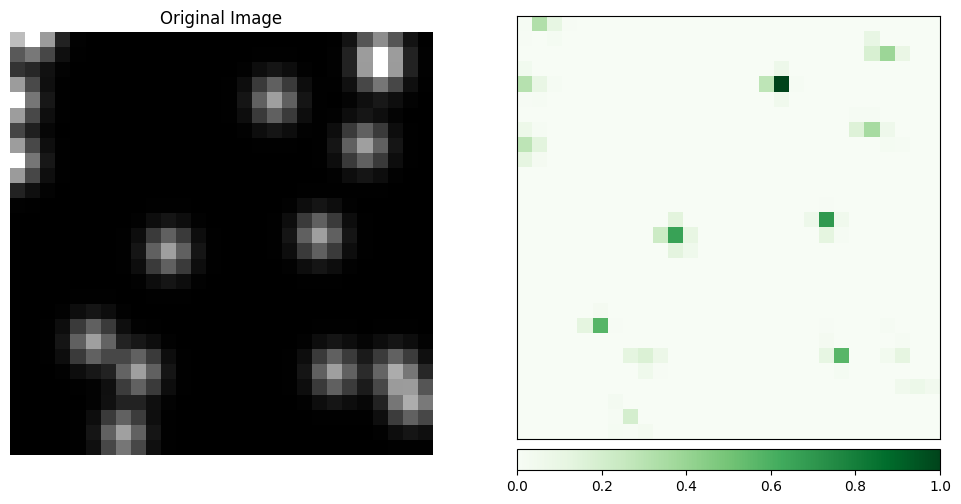

<Figure size 640x480 with 0 Axes>

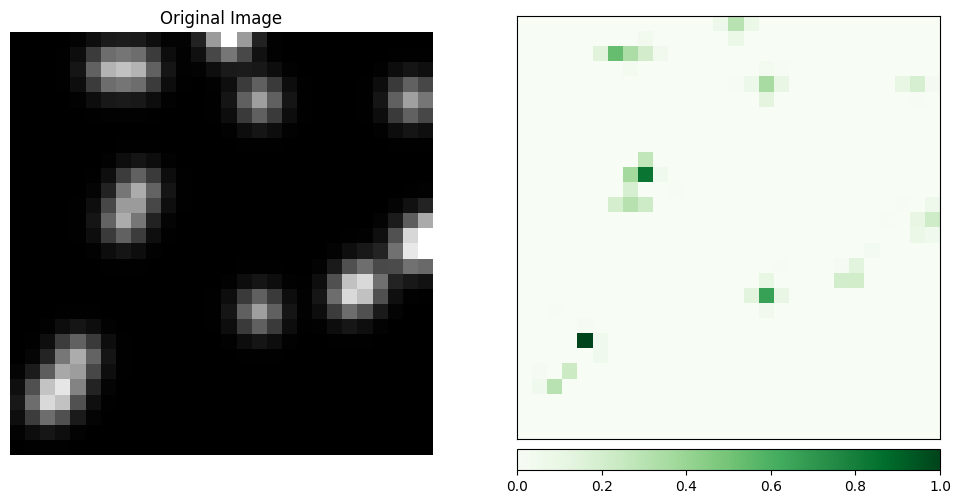

<Figure size 640x480 with 0 Axes>

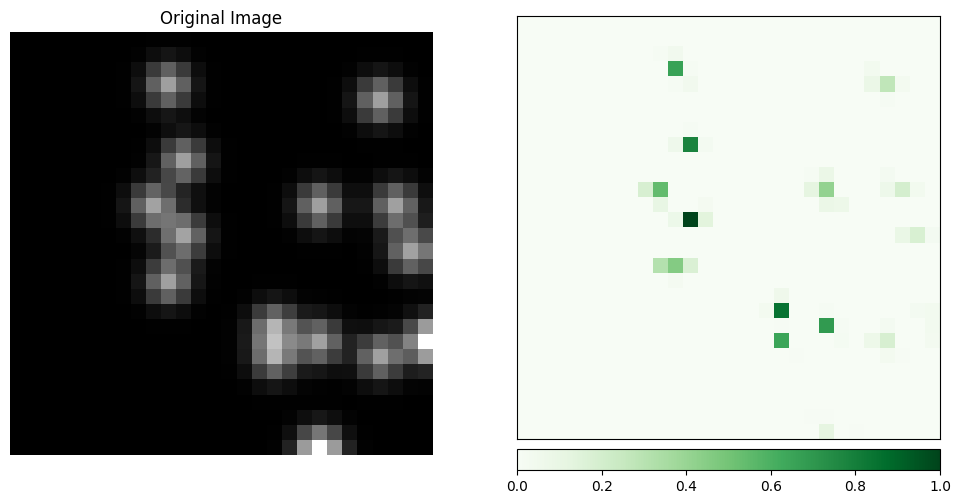

<Figure size 640x480 with 0 Axes>

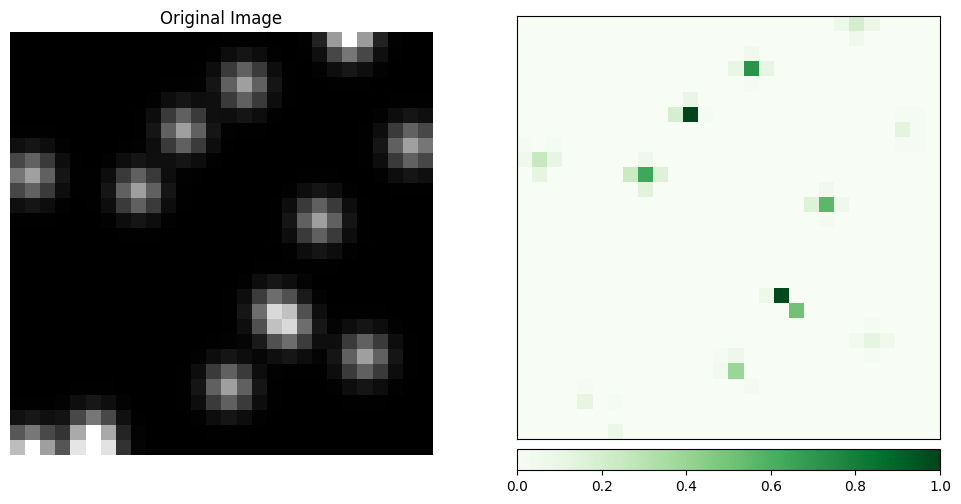

<Figure size 640x480 with 0 Axes>

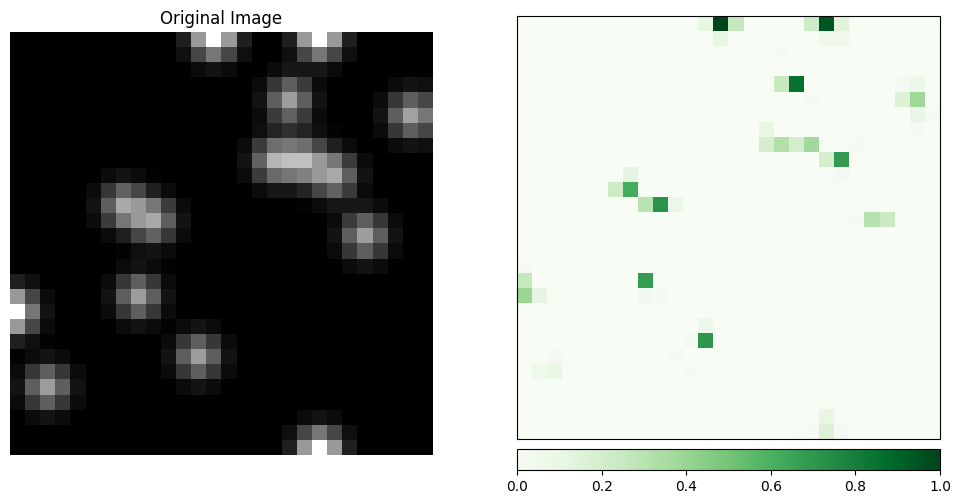

<Figure size 640x480 with 0 Axes>

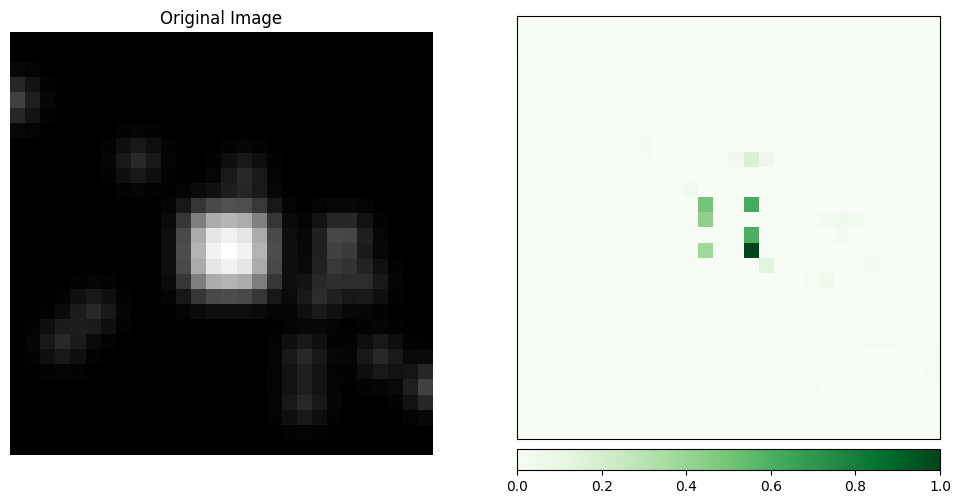

<Figure size 640x480 with 0 Axes>

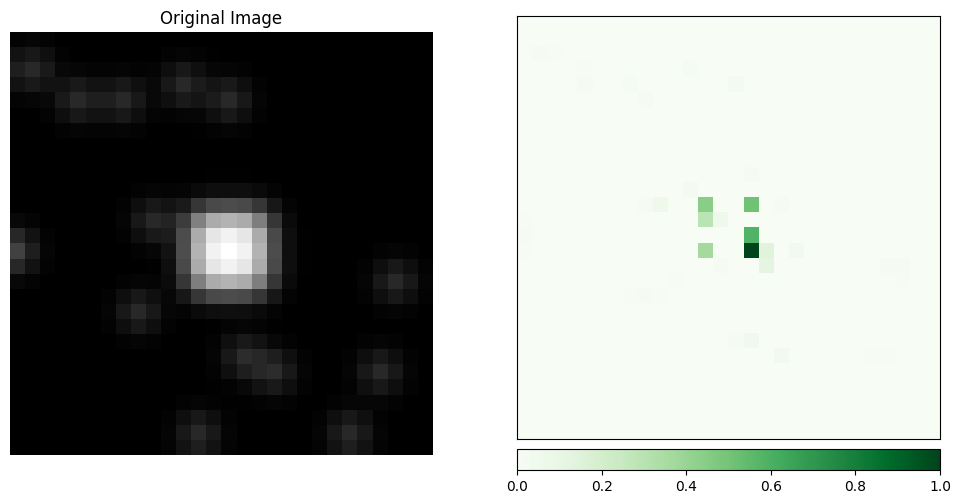

<Figure size 640x480 with 0 Axes>

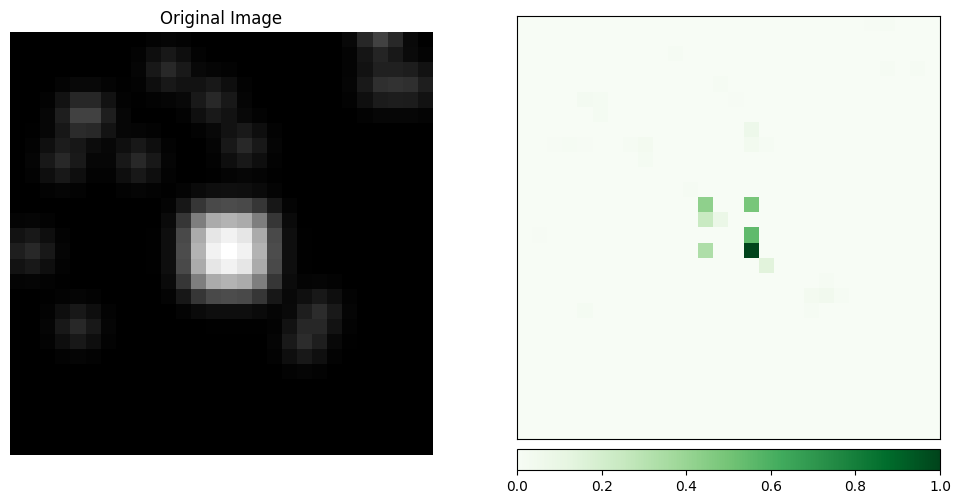

<Figure size 640x480 with 0 Axes>

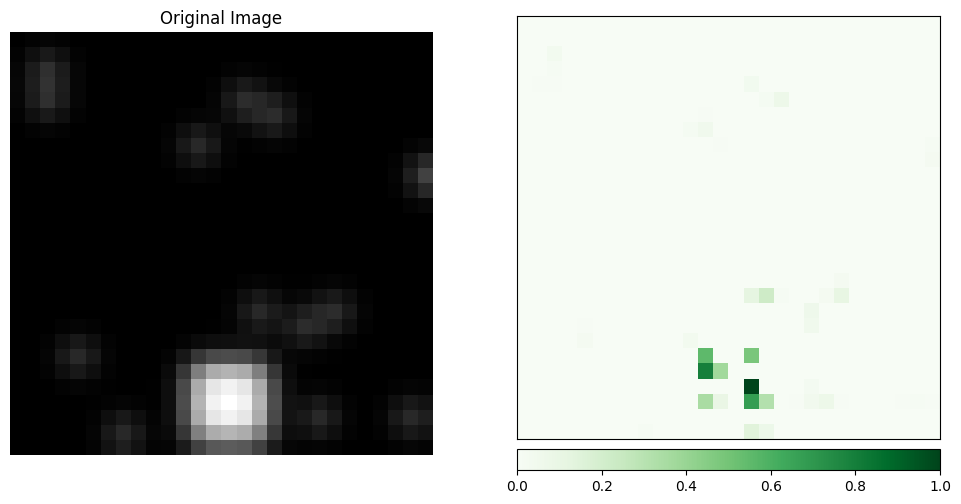

<Figure size 640x480 with 0 Axes>

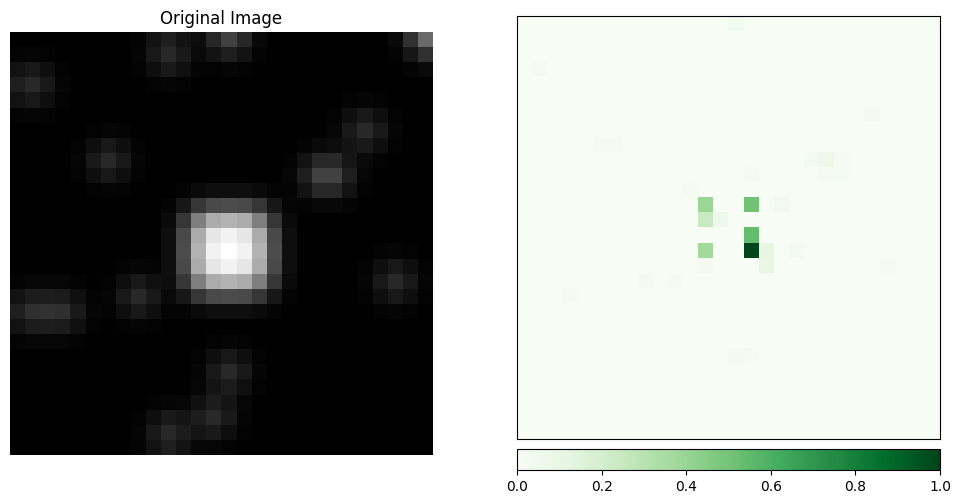

<Figure size 640x480 with 0 Axes>

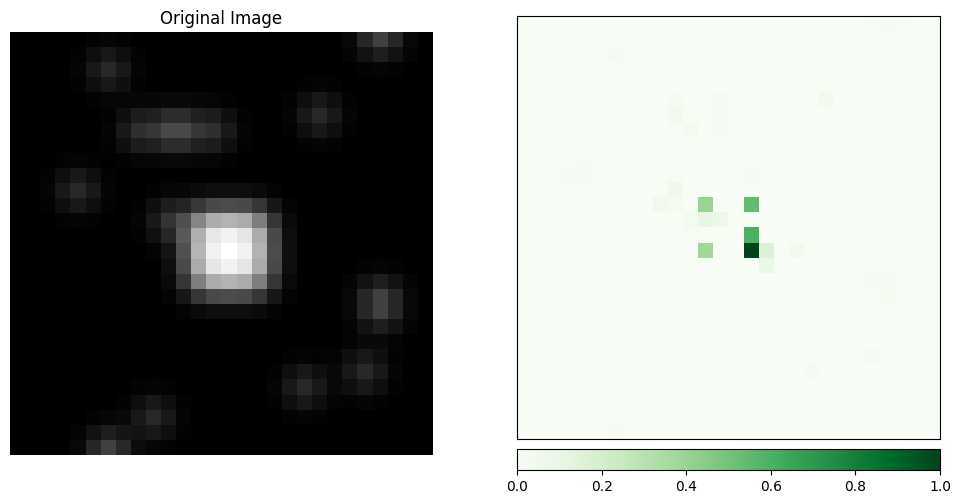

<Figure size 640x480 with 0 Axes>

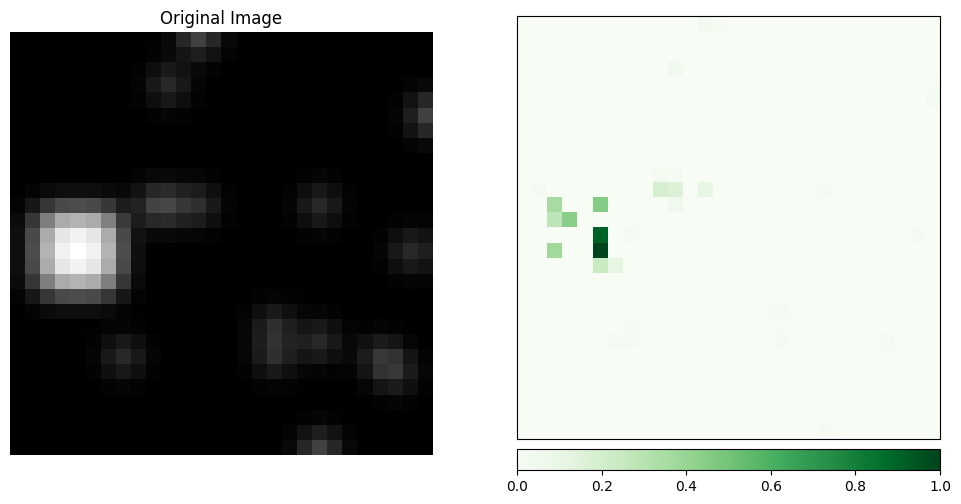

<Figure size 640x480 with 0 Axes>

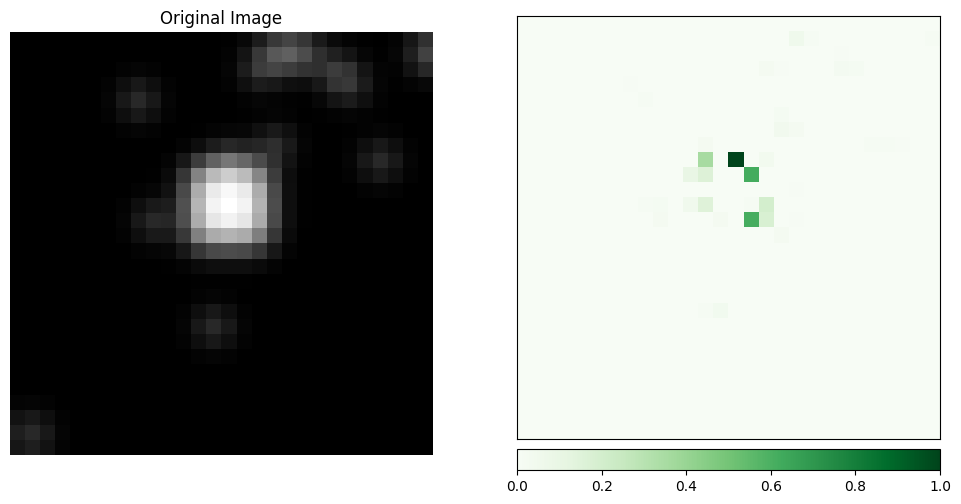

<Figure size 640x480 with 0 Axes>

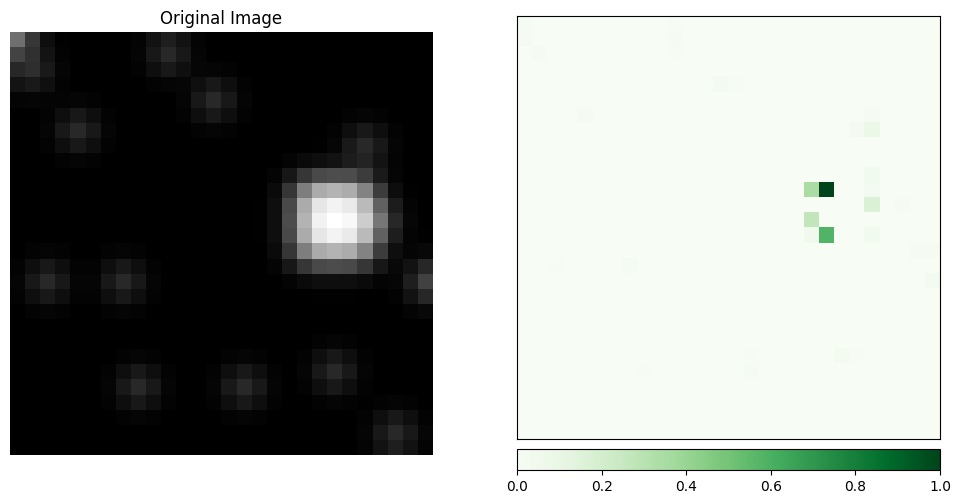

<Figure size 640x480 with 0 Axes>

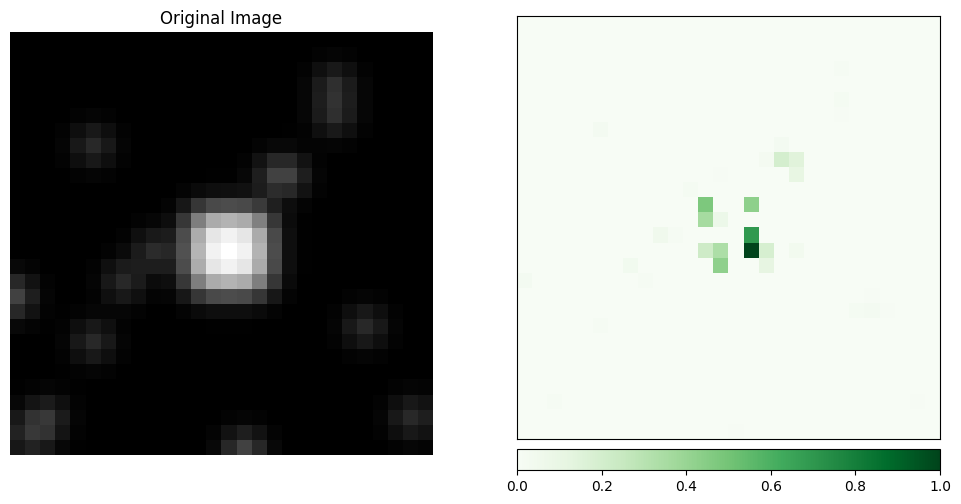

<Figure size 640x480 with 0 Axes>

In [21]:
# Create a flat list of images to match the order of attributions
selected_images_list = [img for _, imgs in selected_images.items() for img in imgs]

# Iterate over the attributions and corresponding images
for idx, (attributions, image) in enumerate(zip(attributions_list, selected_images_list)):
    attr_reshaped = attributions.squeeze().cpu().detach().numpy().reshape(28, 28, 1)
    img_reshaped = image.unsqueeze(0).squeeze().cpu().detach().numpy().reshape(28, 28, 1)

    # Create a single plot with two subplots: one for the original image and one for the attribution
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    # Display the original image on the first subplot
    axes[0].imshow(img_reshaped, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Display the attribution on the second subplot
    _ = viz.visualize_image_attr(attr_reshaped,
                                 img_reshaped,
                                 method='heat_map',
                                 show_colorbar=True,
                                 sign='positive',
                                 outlier_perc=1,
                                 plt_fig_axis=(fig, axes[1]))
    axes[1].set_title("Attribution Map")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

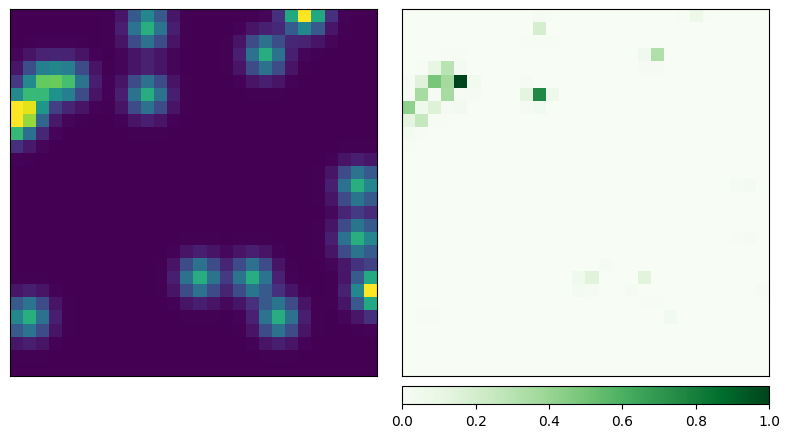

<Figure size 640x480 with 0 Axes>

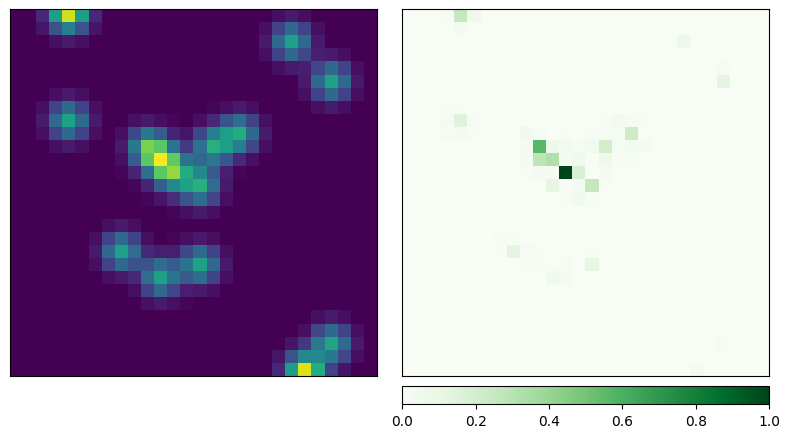

<Figure size 640x480 with 0 Axes>

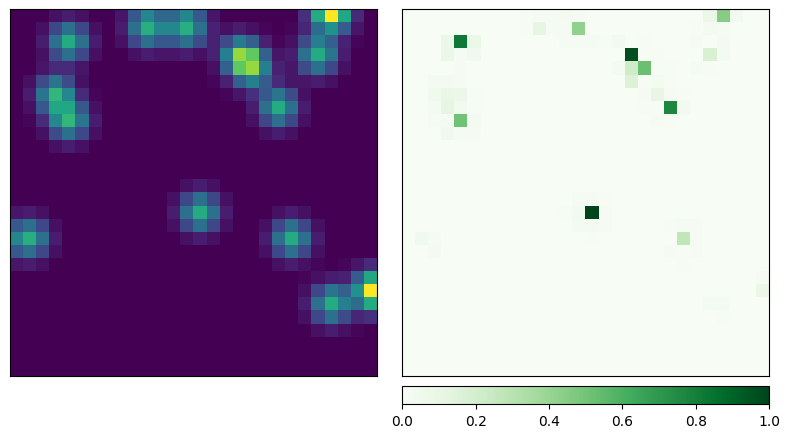

<Figure size 640x480 with 0 Axes>

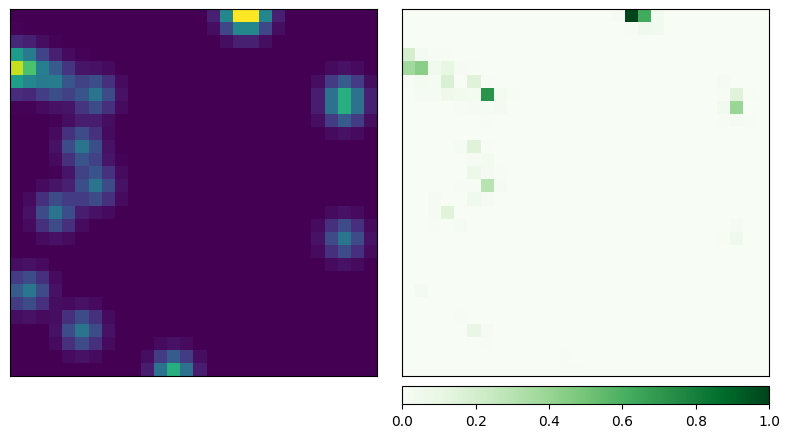

<Figure size 640x480 with 0 Axes>

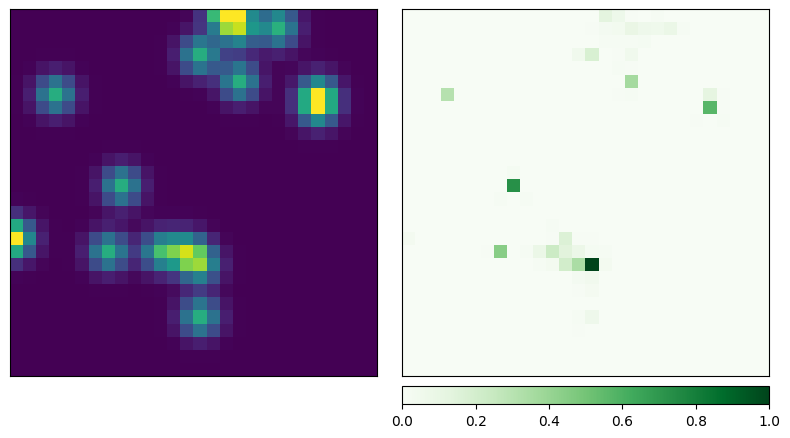

<Figure size 640x480 with 0 Axes>

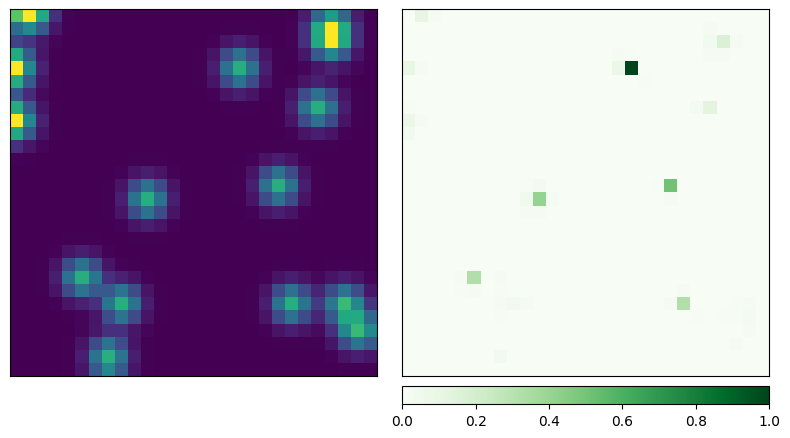

<Figure size 640x480 with 0 Axes>

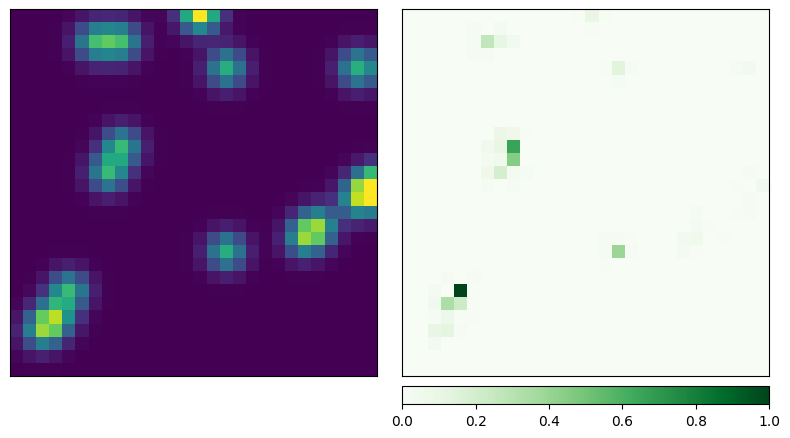

<Figure size 640x480 with 0 Axes>

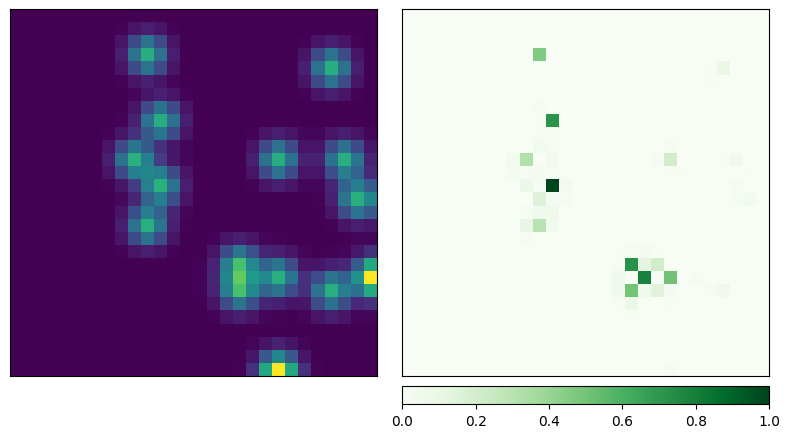

<Figure size 640x480 with 0 Axes>

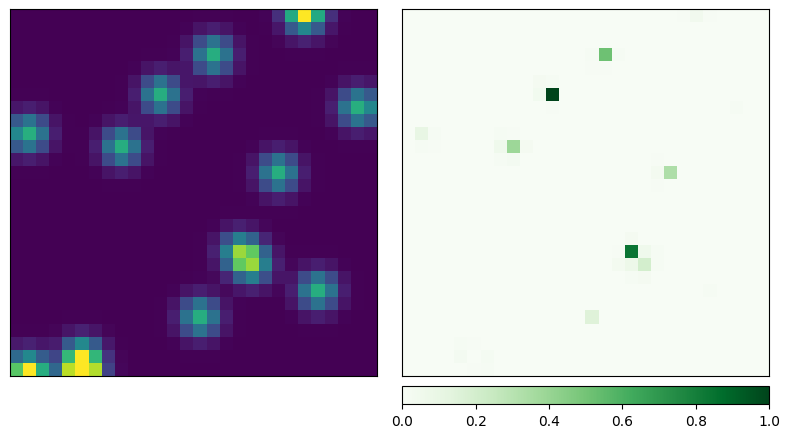

<Figure size 640x480 with 0 Axes>

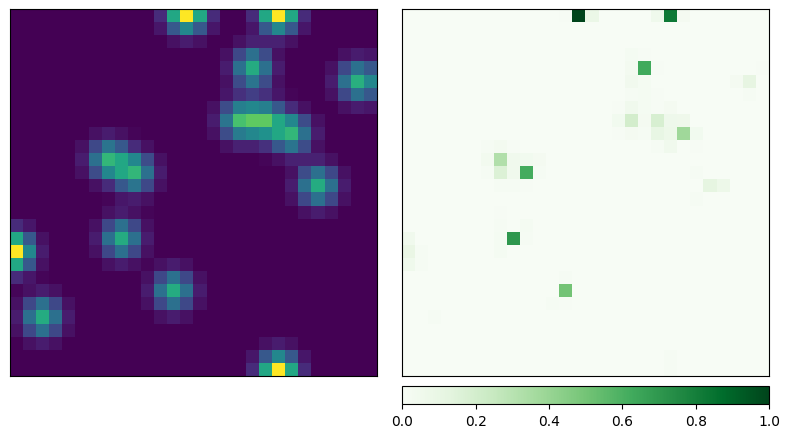

<Figure size 640x480 with 0 Axes>

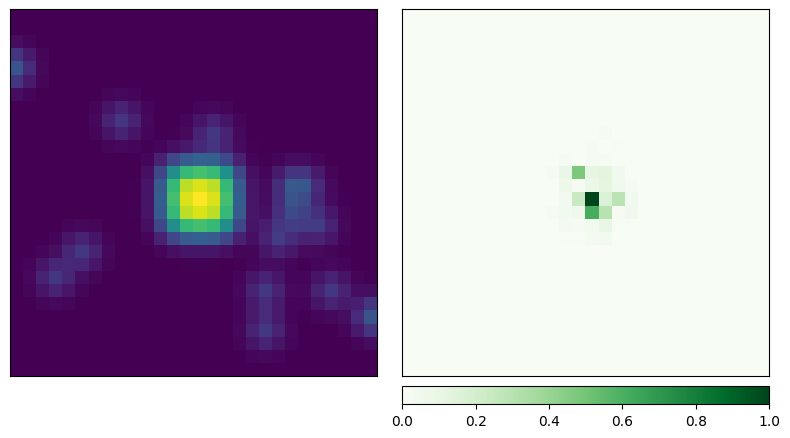

<Figure size 640x480 with 0 Axes>

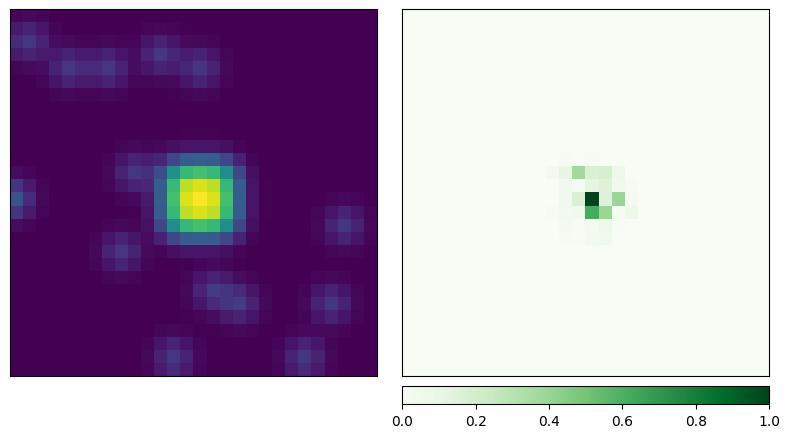

<Figure size 640x480 with 0 Axes>

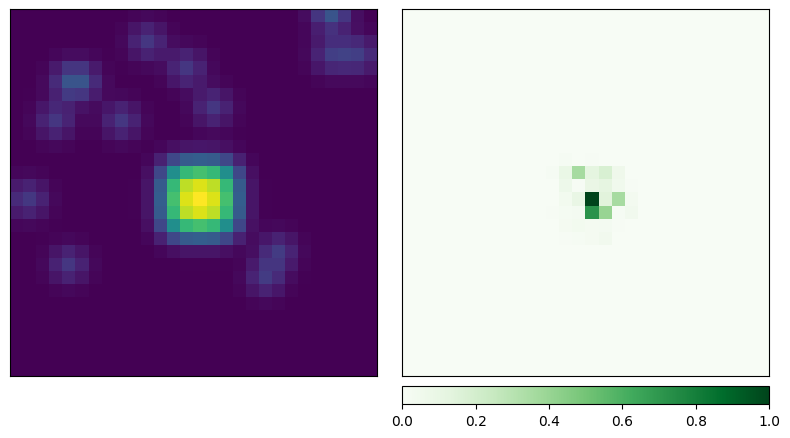

<Figure size 640x480 with 0 Axes>

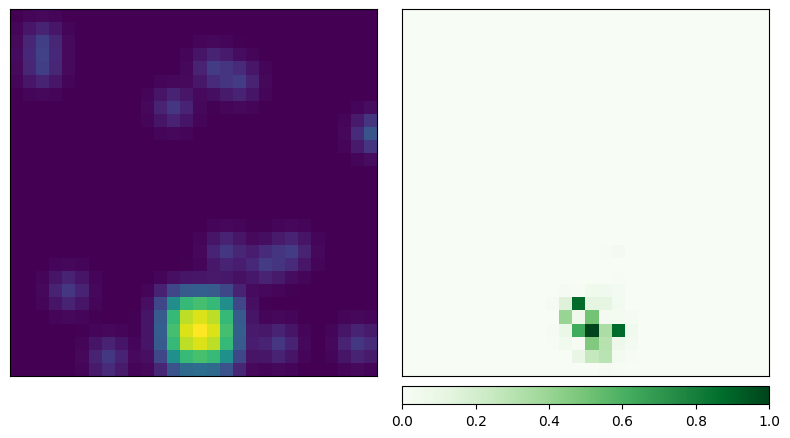

<Figure size 640x480 with 0 Axes>

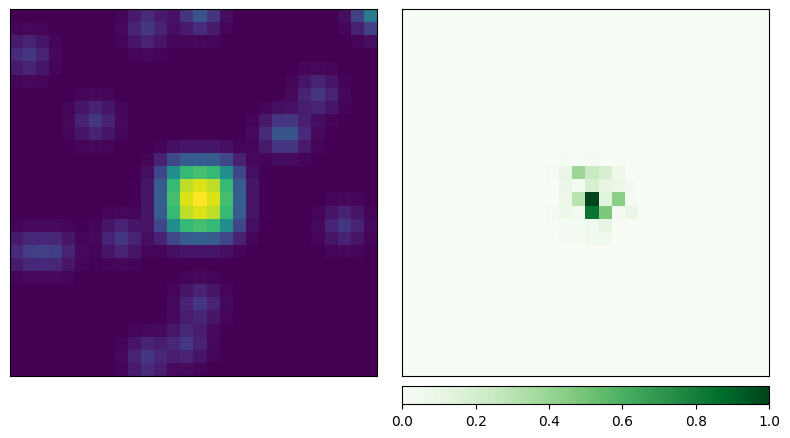

<Figure size 640x480 with 0 Axes>

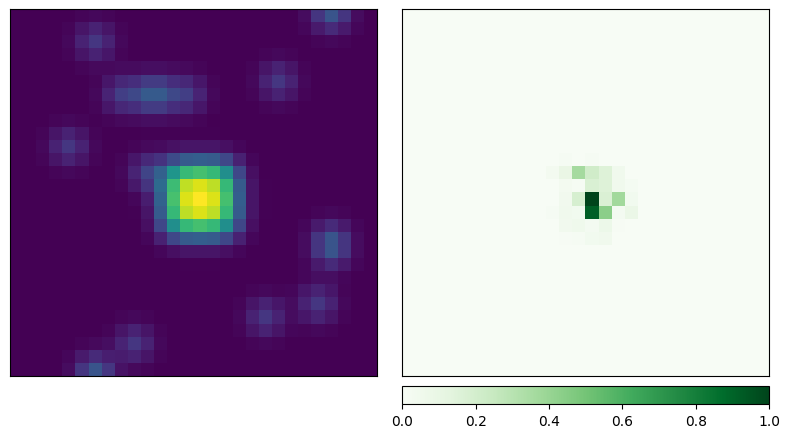

<Figure size 640x480 with 0 Axes>

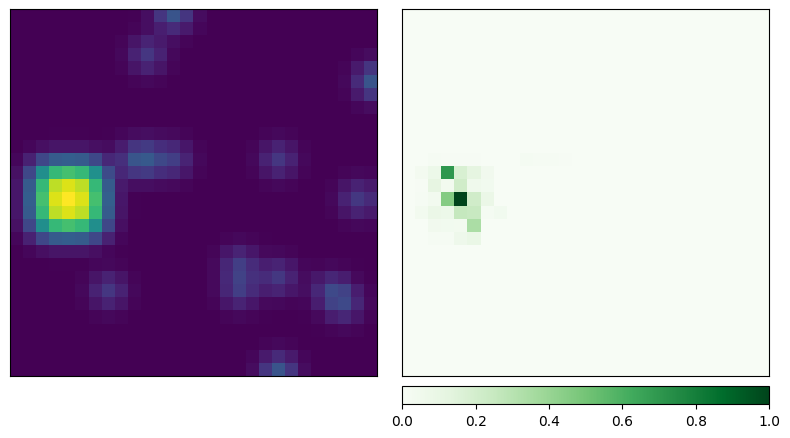

<Figure size 640x480 with 0 Axes>

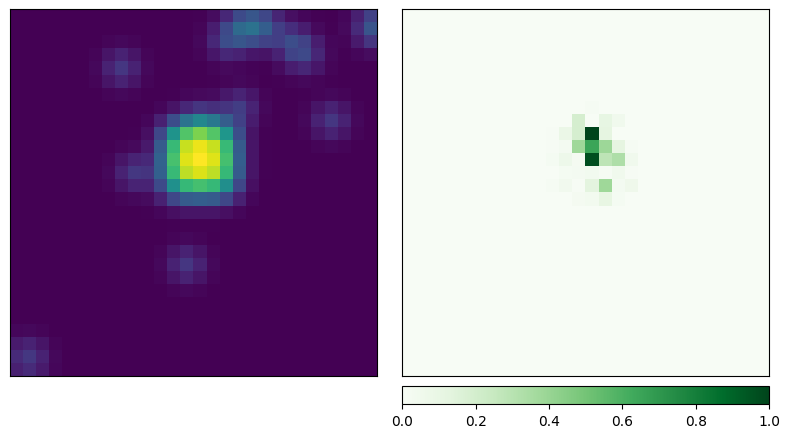

<Figure size 640x480 with 0 Axes>

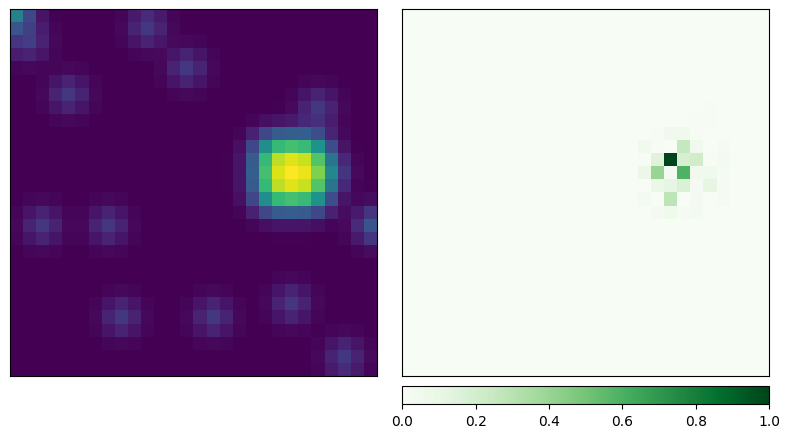

<Figure size 640x480 with 0 Axes>

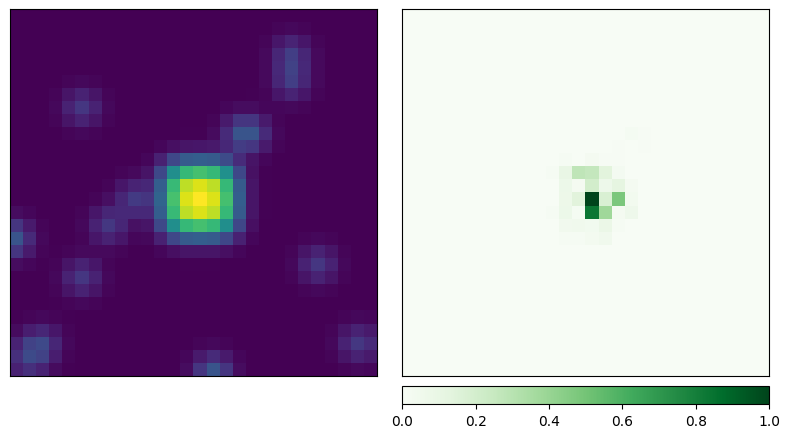

<Figure size 640x480 with 0 Axes>

In [22]:
noise_tunnel = NoiseTunnel(integrated_gradients)
predicted_labels = [res["Predicted Label"] for res in results]
# Loop through each selected image
for image, predicted_label in zip(selected_images_list, predicted_labels):

    # Generate attributions using NoiseTunnel with IntegratedGradients
    input_img = image.unsqueeze(0)  # Add batch dimension
    attributions_ig_nt = noise_tunnel.attribute(input_img, nt_samples=10, nt_type='smoothgrad_sq', target=predicted_label)

    # Prepare the reshaped attribution and image for visualization
    attr_reshaped = attributions_ig_nt.squeeze().cpu().detach().numpy().reshape(28, 28, 1)
    img_reshaped = image.unsqueeze(0).squeeze().cpu().detach().numpy().reshape(28, 28, 1)
    
    # Visualize the original image and the attribution side by side
    _ = viz.visualize_image_attr_multiple(attr_reshaped,
                                          img_reshaped,
                                          ["original_image", "heat_map"],
                                          ["all", "positive"],
                                          show_colorbar=True)
    _ = plt.tight_layout()
    _ = plt.show()

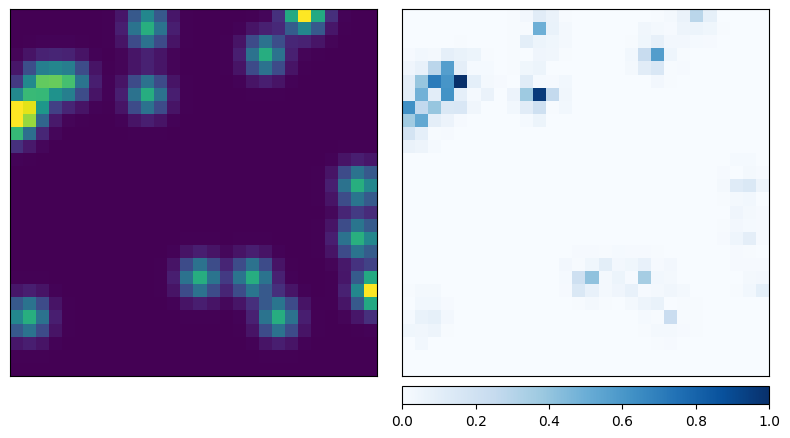

<Figure size 640x480 with 0 Axes>

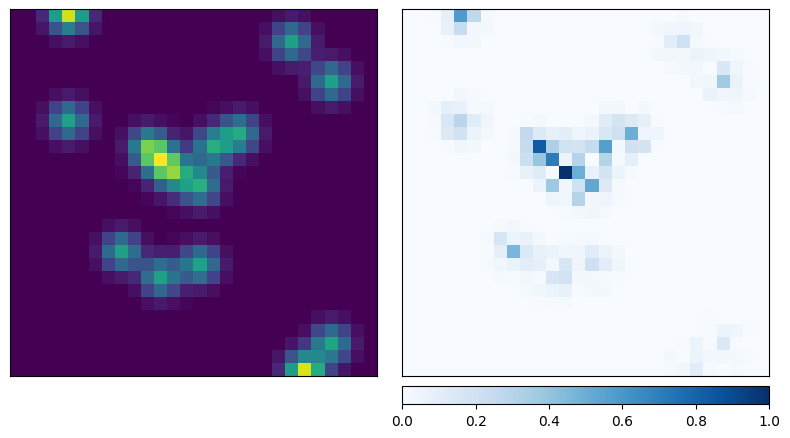

<Figure size 640x480 with 0 Axes>

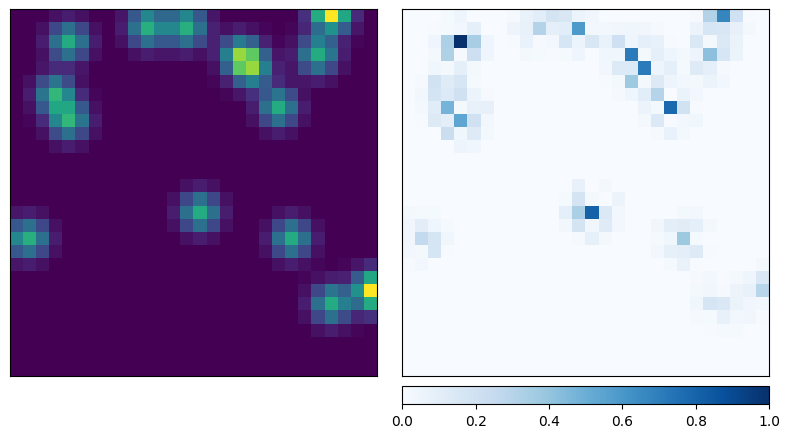

<Figure size 640x480 with 0 Axes>

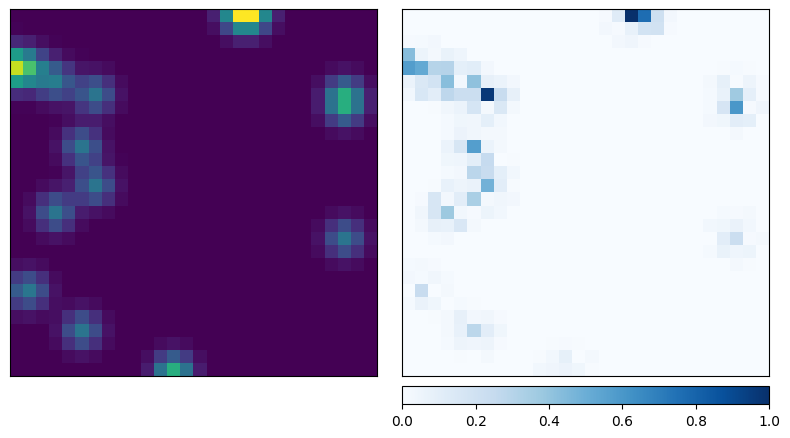

<Figure size 640x480 with 0 Axes>

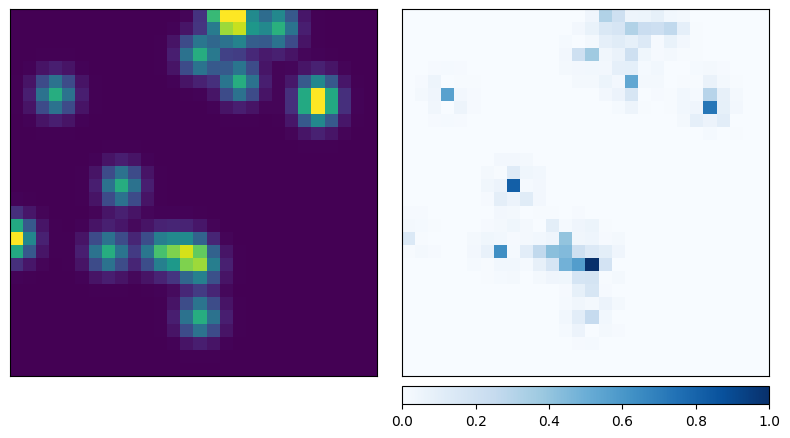

<Figure size 640x480 with 0 Axes>

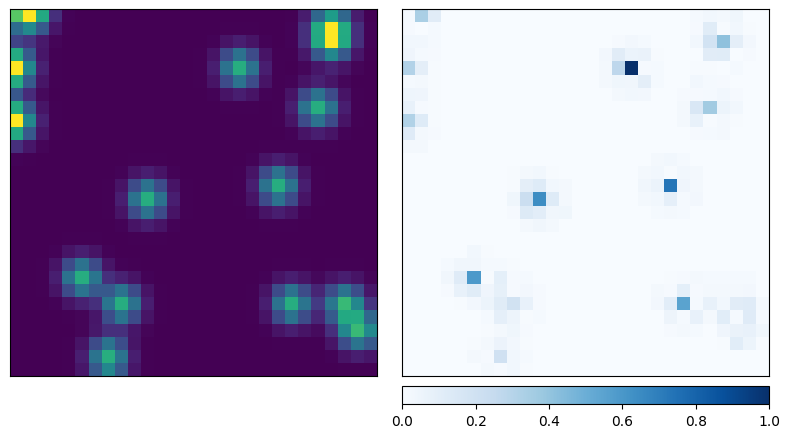

<Figure size 640x480 with 0 Axes>

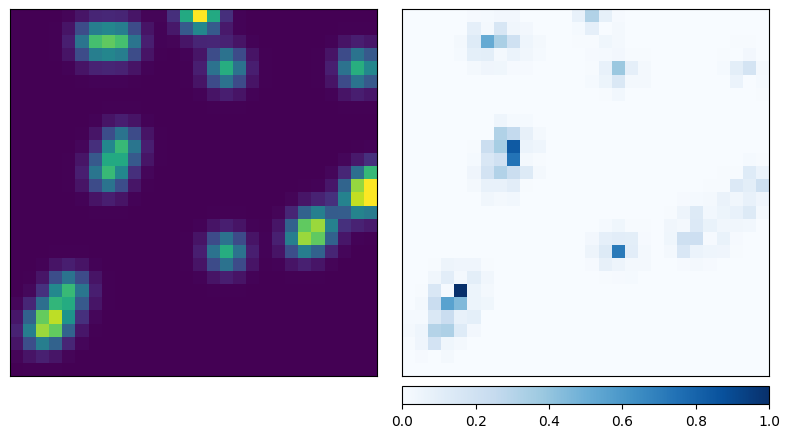

<Figure size 640x480 with 0 Axes>

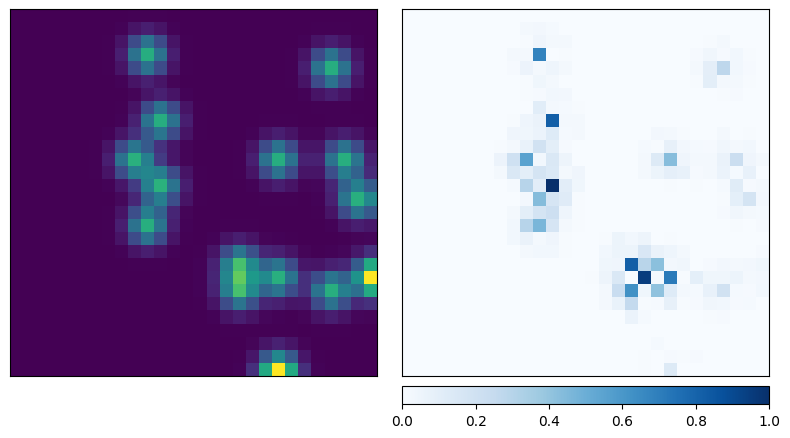

<Figure size 640x480 with 0 Axes>

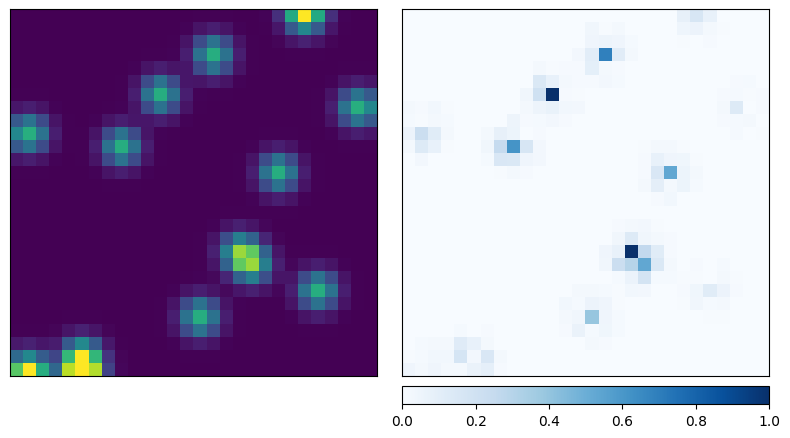

<Figure size 640x480 with 0 Axes>

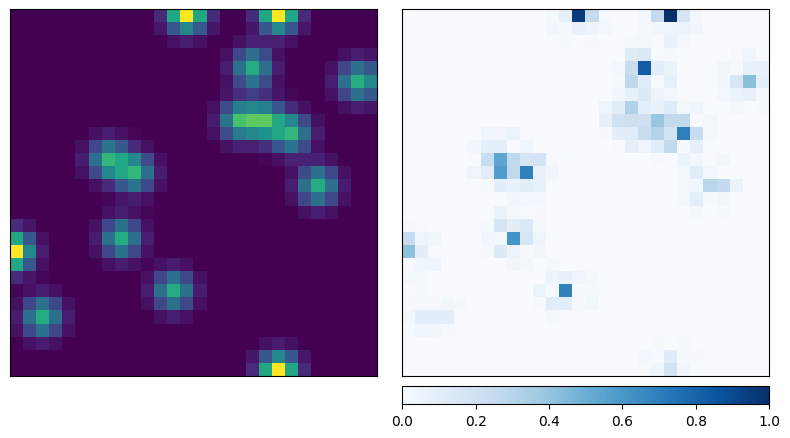

<Figure size 640x480 with 0 Axes>

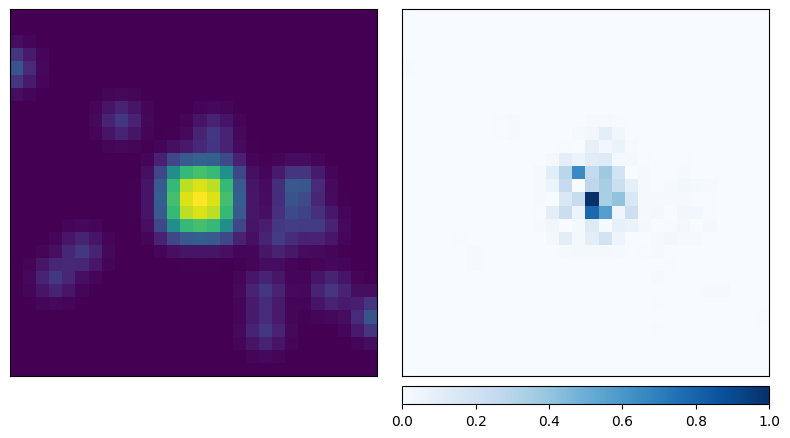

<Figure size 640x480 with 0 Axes>

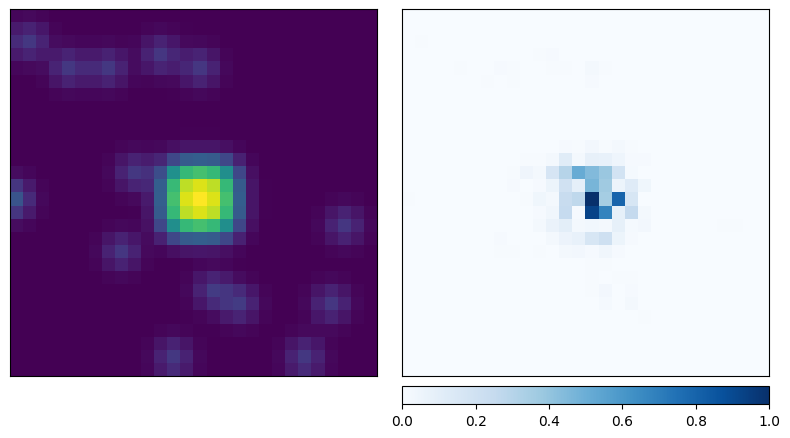

<Figure size 640x480 with 0 Axes>

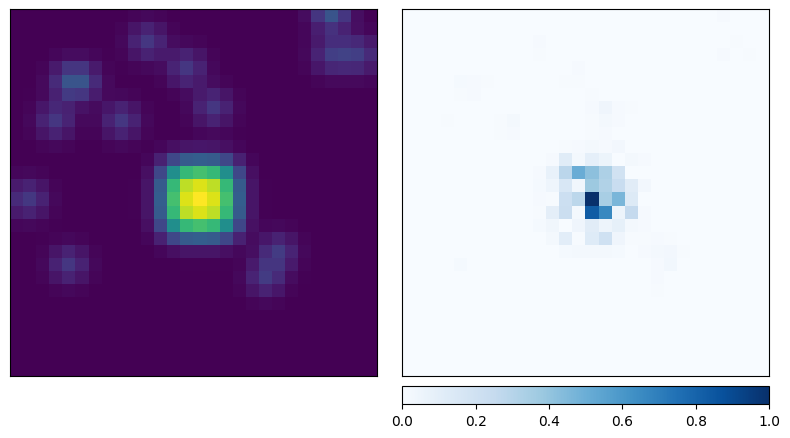

<Figure size 640x480 with 0 Axes>

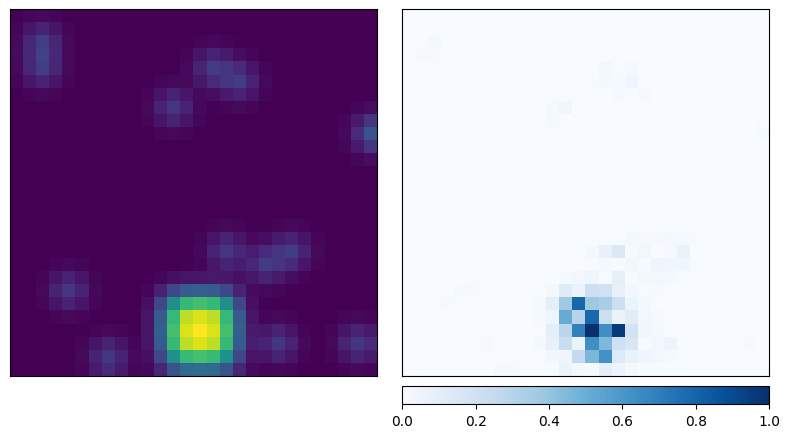

<Figure size 640x480 with 0 Axes>

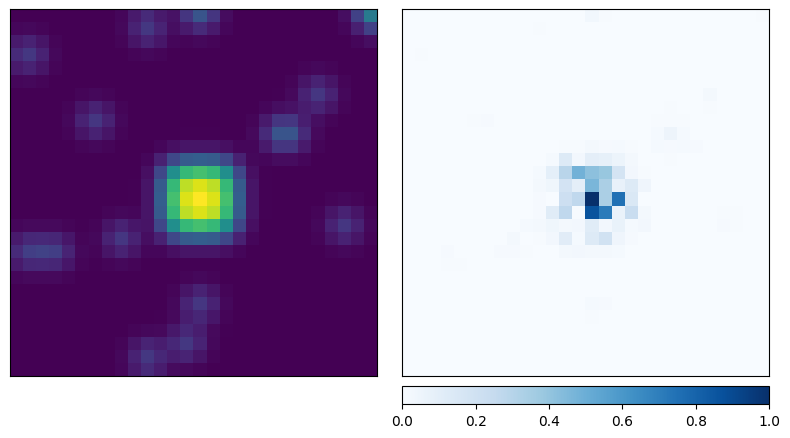

<Figure size 640x480 with 0 Axes>

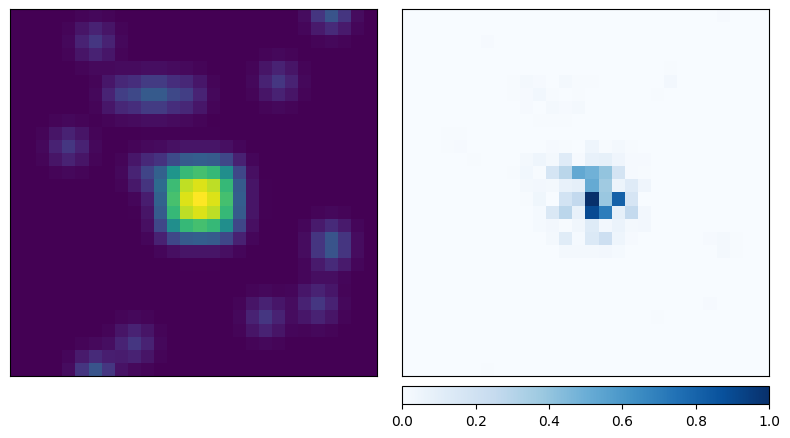

<Figure size 640x480 with 0 Axes>

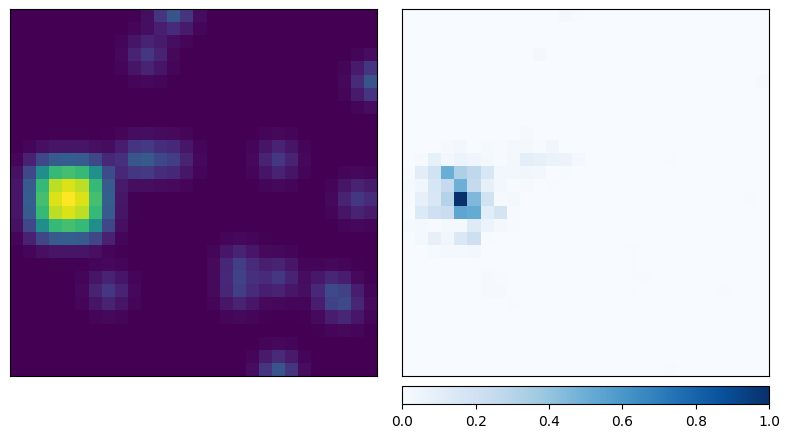

<Figure size 640x480 with 0 Axes>

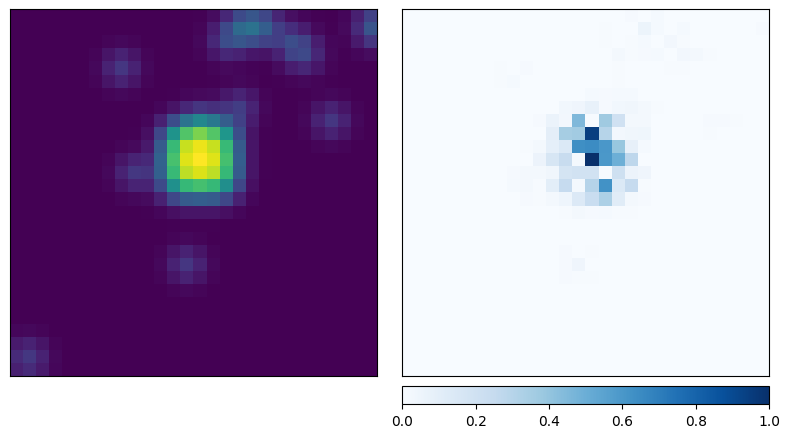

<Figure size 640x480 with 0 Axes>

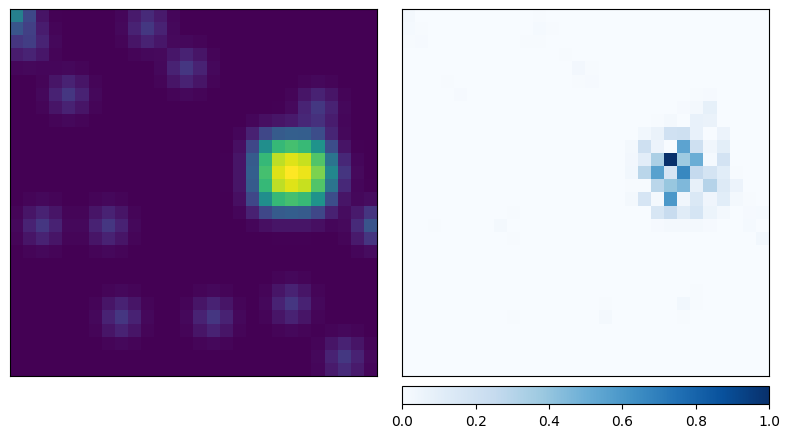

<Figure size 640x480 with 0 Axes>

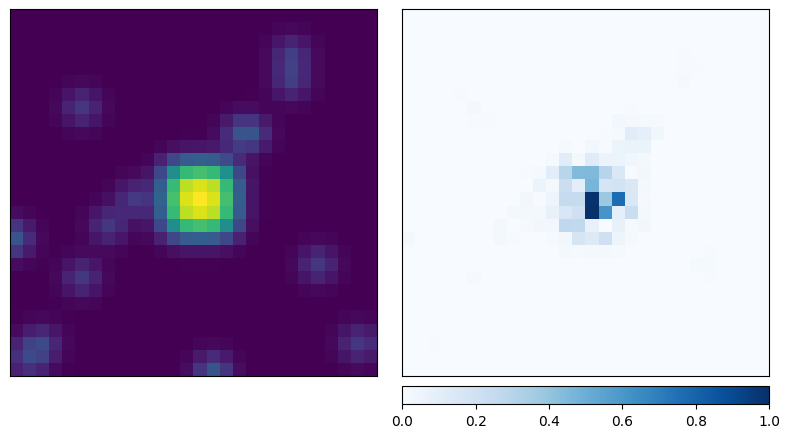

<Figure size 640x480 with 0 Axes>

In [23]:
gradient_shap = GradientShap(model)
# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Loop through each selected image
for image, predicted_label in zip(selected_images_list, predicted_labels):
    
    # Prepare the image for model
    input_img = image.unsqueeze(0)  # Add batch dimension
    
    # Defining baseline distribution of images for GradientShap
    rand_img_dist = torch.cat([input_img * 0, input_img * 1])
    
    # Generate attributions using GradientShap
    attributions_gs = gradient_shap.attribute(input_img,
                                              n_samples=50,
                                              stdevs=0.0001,
                                              baselines=rand_img_dist,
                                              target=predicted_label)
    
    # Prepare the reshaped attribution and image for visualization
    attr_reshaped = attributions_gs.squeeze().cpu().detach().numpy().reshape(28, 28, 1)
    img_reshaped = image.unsqueeze(0).squeeze().cpu().detach().numpy().reshape(28, 28, 1)
    
    # Visualize the original image and the attribution side by side
    _ = viz.visualize_image_attr_multiple(attr_reshaped,
                                          img_reshaped,
                                          ["original_image", "heat_map"],
                                          ["all", "absolute_value"],
                                          show_colorbar=True)
    _ = plt.tight_layout()
    _ = plt.show()

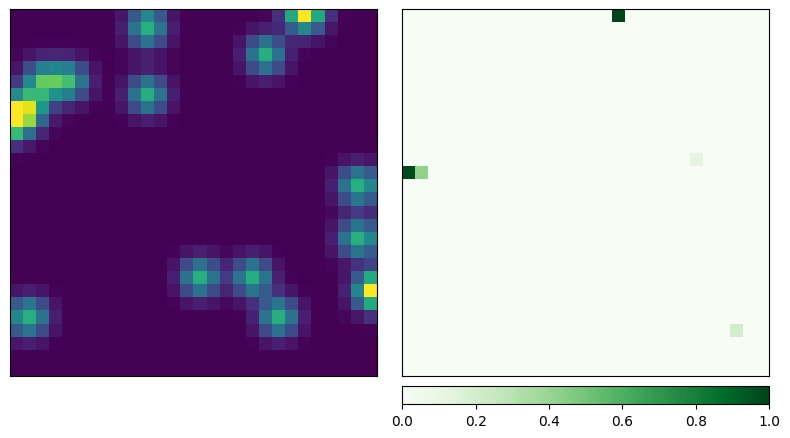

<Figure size 640x480 with 0 Axes>

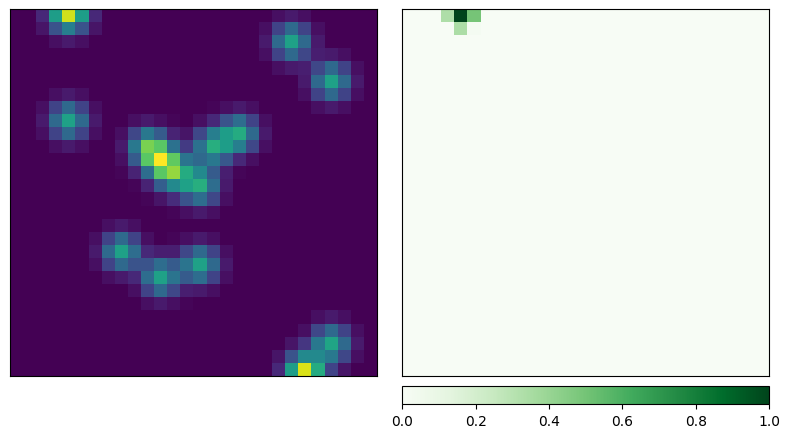

<Figure size 640x480 with 0 Axes>

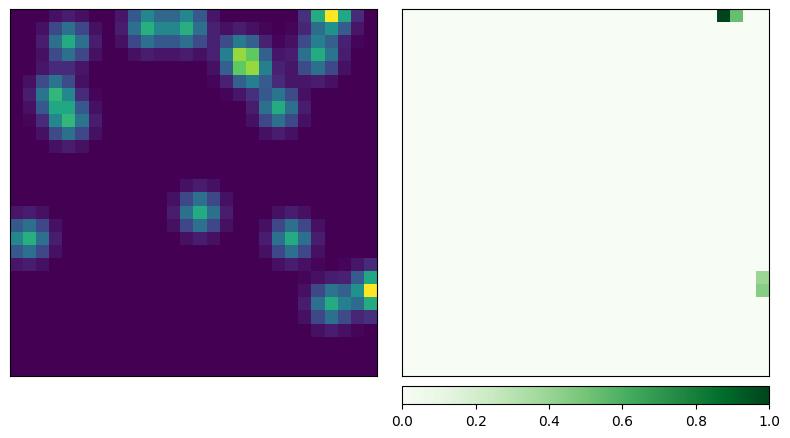

<Figure size 640x480 with 0 Axes>

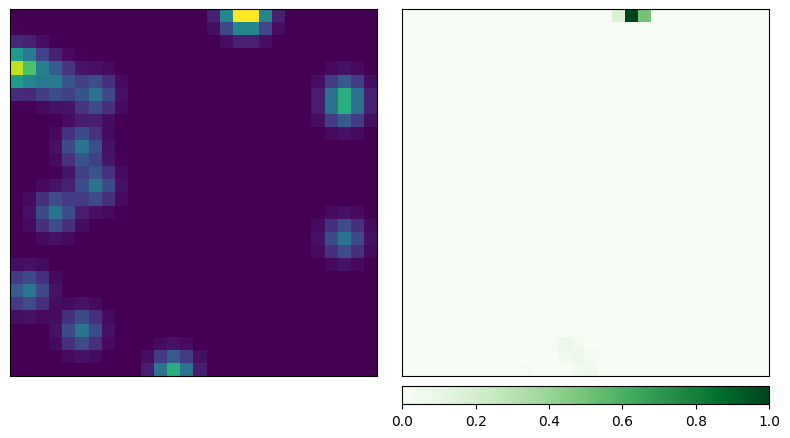

<Figure size 640x480 with 0 Axes>

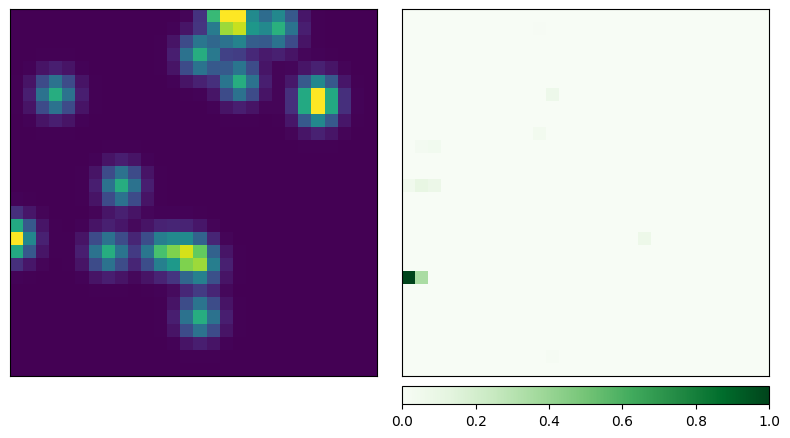

<Figure size 640x480 with 0 Axes>

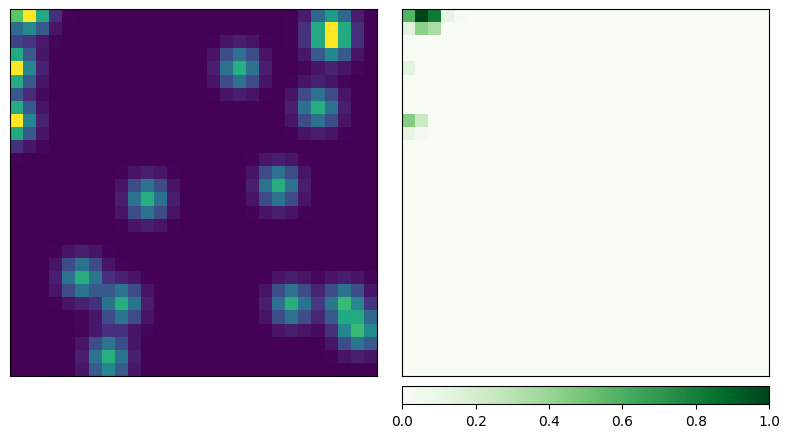

<Figure size 640x480 with 0 Axes>

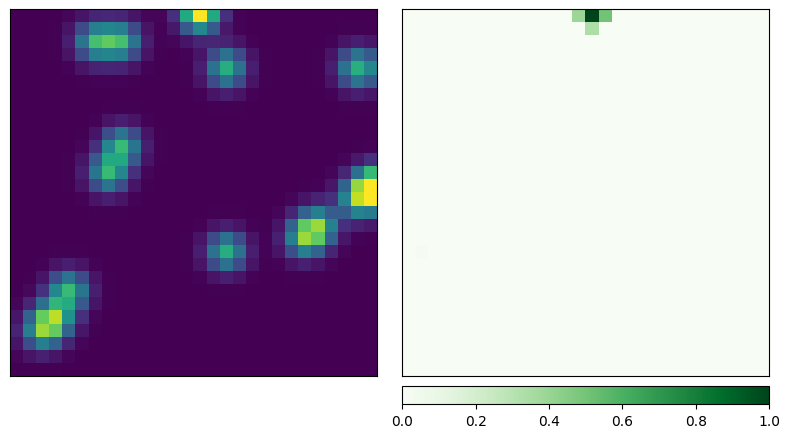

<Figure size 640x480 with 0 Axes>

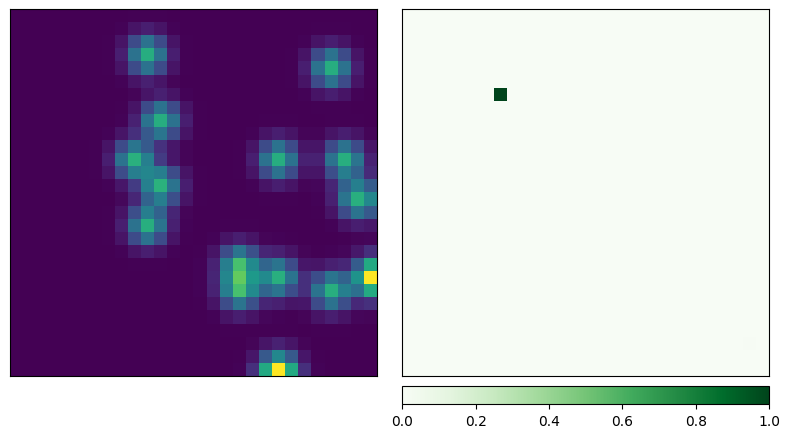

<Figure size 640x480 with 0 Axes>

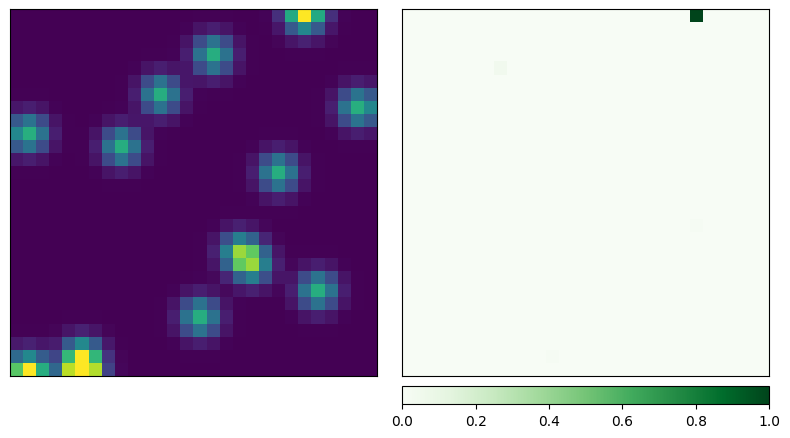

<Figure size 640x480 with 0 Axes>

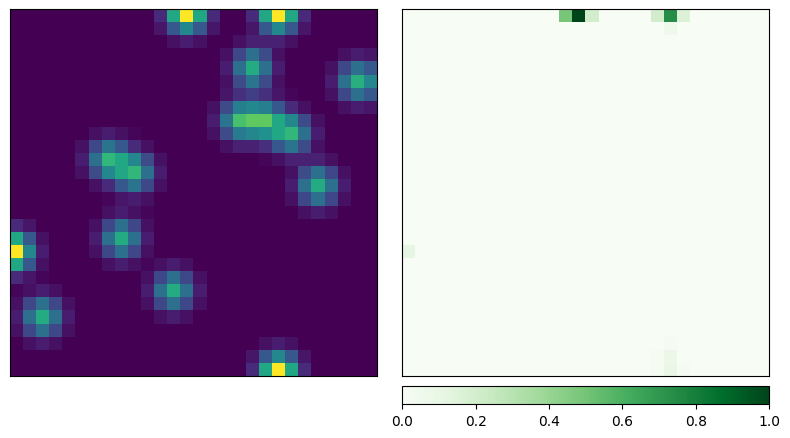

<Figure size 640x480 with 0 Axes>

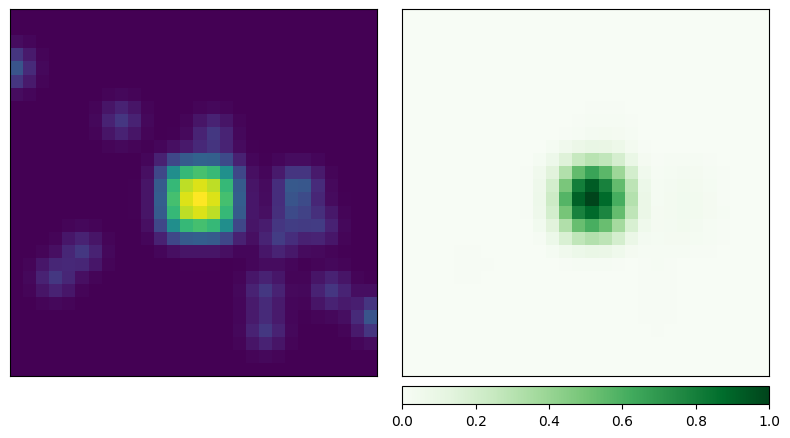

<Figure size 640x480 with 0 Axes>

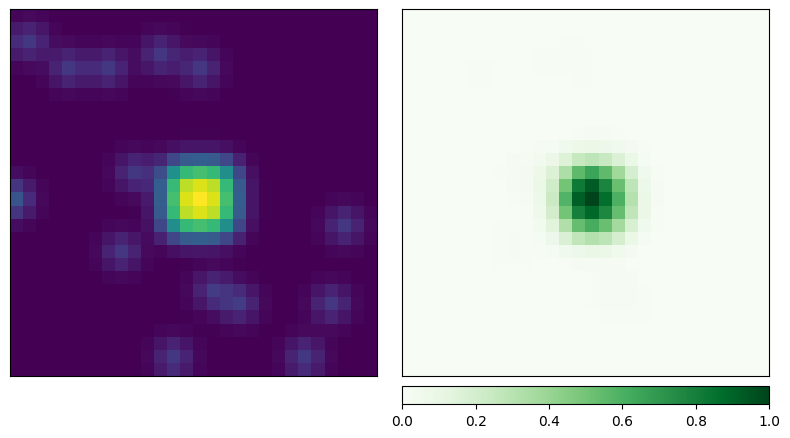

<Figure size 640x480 with 0 Axes>

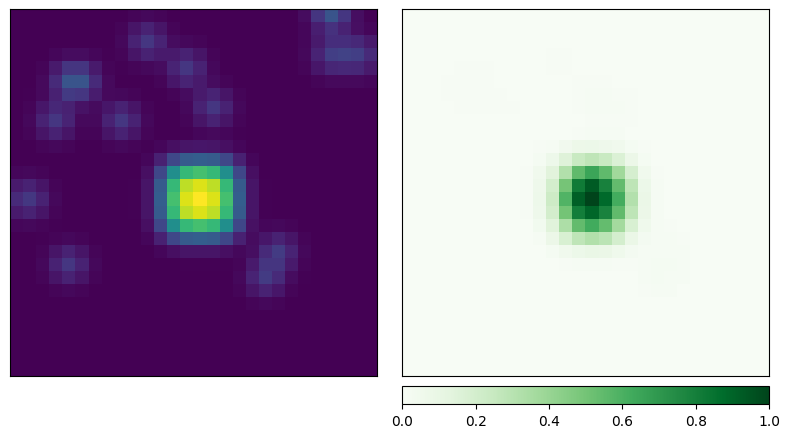

<Figure size 640x480 with 0 Axes>

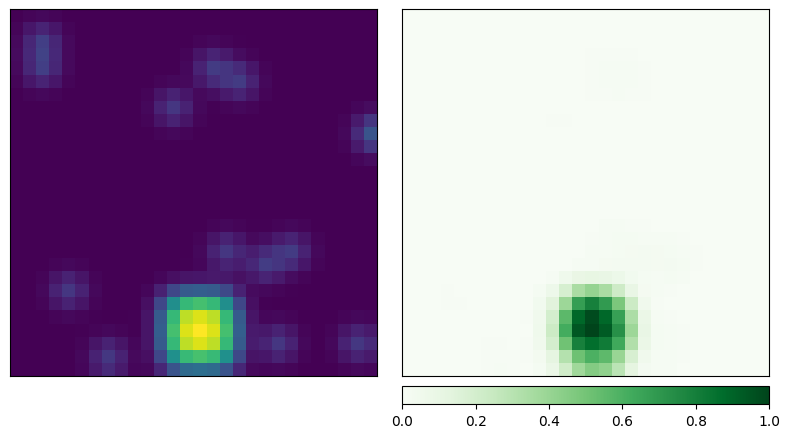

<Figure size 640x480 with 0 Axes>

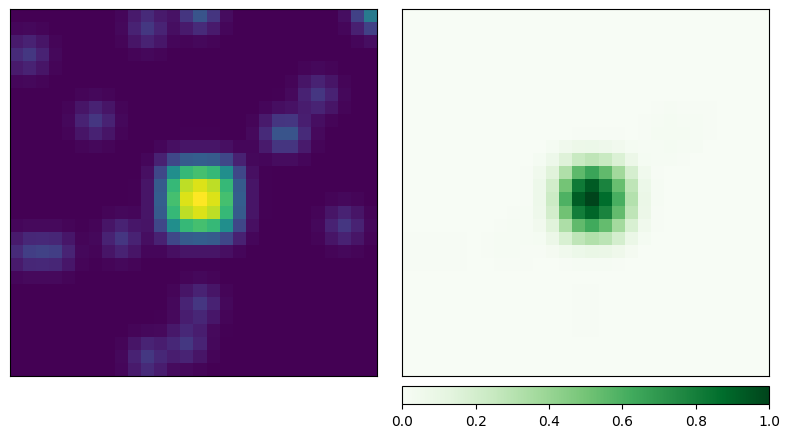

<Figure size 640x480 with 0 Axes>

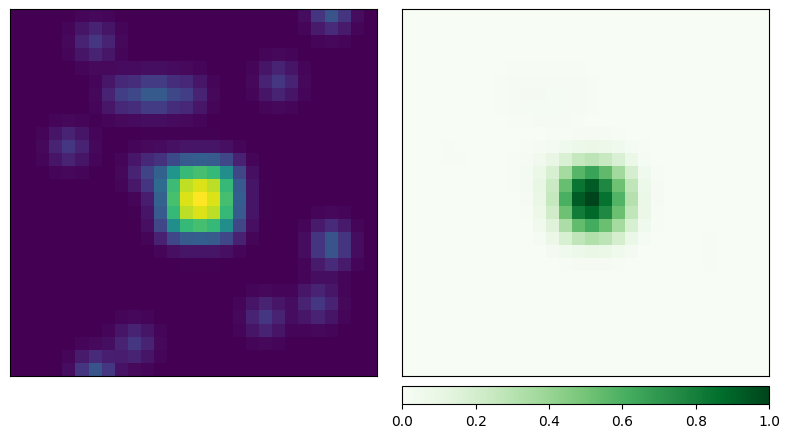

<Figure size 640x480 with 0 Axes>

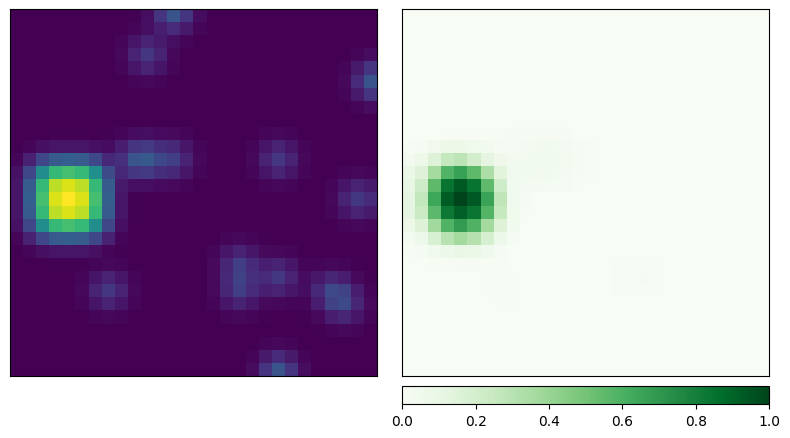

<Figure size 640x480 with 0 Axes>

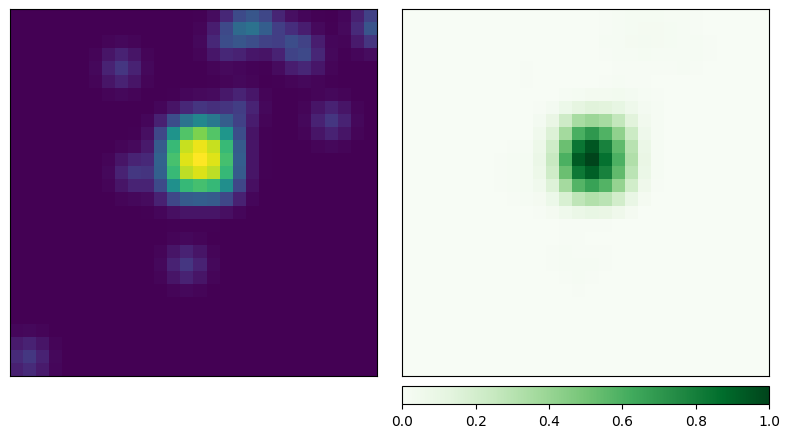

<Figure size 640x480 with 0 Axes>

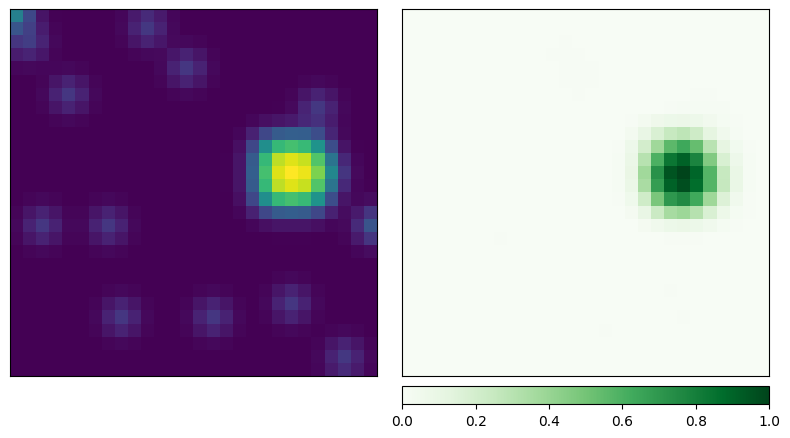

<Figure size 640x480 with 0 Axes>

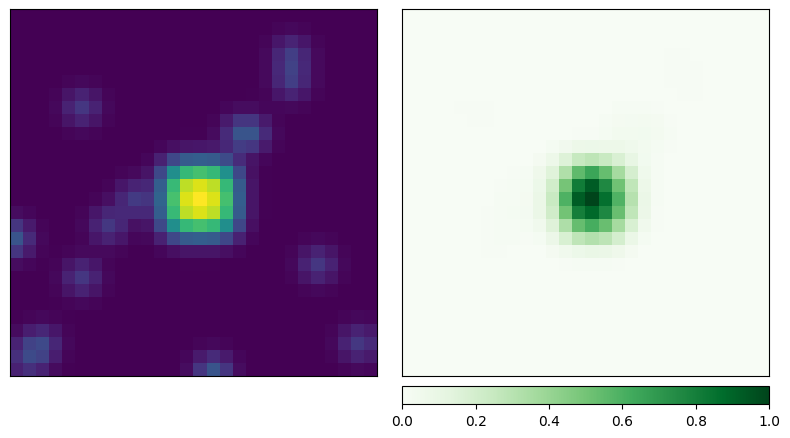

<Figure size 640x480 with 0 Axes>

In [24]:
occlusion = Occlusion(model)

# Loop through each selected image
for image, predicted_label in zip(selected_images_list, predicted_labels):

    # Generate attributions using Occlusion
    input_img = image.unsqueeze(0)  # Add batch dimension
    attributions_occ = occlusion.attribute(input_img,
                                           strides=(1, 1, 1),
                                           target=predicted_label,
                                           sliding_window_shapes=(1, 2, 2),
                                           baselines=0)

    # Prepare the reshaped attribution and image for visualization
    attr_reshaped = attributions_occ.squeeze().cpu().detach().numpy().reshape(28, 28, 1)
    img_reshaped = image.unsqueeze(0).squeeze().cpu().detach().numpy().reshape(28, 28, 1)
    
    # Visualize the original image and the attribution side by side
    _ = viz.visualize_image_attr_multiple(attr_reshaped,
                                          img_reshaped,
                                          ["original_image", "heat_map"],
                                          ["all", "positive"],
                                          show_colorbar=True,
                                          outlier_perc=2)
    plt.tight_layout()
    plt.show()